### Correlations:

Correlation or dependence is any statistical relationship, whether causal or not. In the broadest sense, "correlation" may indicate any type of association.

Correlations are useful because they can indicate a predictive relationship that can be exploited in practice.

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import scipy.stats as ss
import math
from collections import Counter
from scipy import signal
import warnings

# Suppress all UserWarning warnings
warnings.simplefilter(action='ignore', category=UserWarning)
#import yfinance as yf

# Set random seed for reproducibility
np.random.seed(42)

# Number of samples
samples = 100

# Numeric columns
num_cols = 3
data = {f'X{i}': np.random.rand(samples) for i in range(1, num_cols + 1)}

# Date column
start_date = datetime(2020, 1, 1)
end_date = datetime(2023, 1, 1)
date_range = [start_date + timedelta(days=random.randint(0, (end_date-start_date).days)) for _ in range(samples)]
data['Date'] = date_range

# Categorical columns
categories1 = ['A', 'B', 'C', 'D', 'E']
categories2 = ['Low', 'Medium', 'High']
data['Category1'] = [random.choice(categories1) for _ in range(samples)]
data['Category2'] = [random.choice(categories2) for _ in range(samples)]

# Cluster ID column
clusters = list(range(10))  # 10 clusters
data['ClusterID'] = [random.choice(clusters) for _ in range(samples)]

# Create DataFrame
df = pd.DataFrame(data)
df = df.sort_values('Date').reset_index(drop=True)
df.index = df['Date']
df = df.drop(columns=['Date'])

#pandas option to show all columns 
pd.set_option('display.max.columns', None)

#global figure size for matplotlib
plt.rcParams['figure.figsize'] = (18, 6)

df.head()

,X1,X2,X3,Category1,Category2,ClusterID
Date,,,,,,
2020-01-28,0.139494,0.896091,0.568309,D,Medium,3
2020-01-31,0.623298,0.113474,0.337995,D,High,7
2020-02-11,0.493796,0.349210,0.522243,A,Medium,5
2020-03-02,0.310982,0.257942,0.578280,D,High,3
2020-03-04,0.020584,0.289751,0.548734,A,High,8


### Correlations: Pearson

In general, this coefficient (Pearson) can be interpreted as follows:
- Magnitudes:
    - .00-.19 `very weak`
    - .20-.39 `weak`
    - .40-.59 `moderate`
    - .60-.79 `strong`
    - .80-1.0 `very strong`
- Sign:
    - positive indicate a proportional relationship
    - negative indicate a inverse proportional relationship

Pearson's correlation have some mathematical assumptions in order to be used properly. These can be summerized as:
 - variables must be continous
 - data must be linear
 - outliers affects the score

It is defined as:

 $$ Correlation = \frac{\sum{(X - X_{MEAN})*(Y - Y_{MEAN})}}{\sqrt{\sum{(X - X_{MEAN})^2}*\sum{(Y - Y_{MEAN})^2}}} $$

In [2]:
cor_matrix_tri = df.select_dtypes(include=['number', 'float64', 'int64']).corr(method='pearson')
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,X1,X2,X3,ClusterID
X1,1.000000,-0.034033,-0.037654,0.072309
X2,-0.034033,1.000000,-0.146354,-0.027734
X3,-0.037654,-0.146354,1.000000,-0.110419
ClusterID,0.072309,-0.027734,-0.110419,1.000000


### Correlations: Spearman

- Spearman does not assumes linear relationship nor restricst ordinal variables. 
- It follows the same interpretation as the Pearson score

It is defined as:

 $$ Correlation = 1 - (\frac{(6*\sum{(X_{RANK} - Y_{RANK})^2})}{(N*(N^2-1))}) $$

where:
- N is the number of data points

In [3]:
cor_matrix_tri = df.select_dtypes(include=['number', 'float64', 'int64']).corr(method='spearman')
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,X1,X2,X3,ClusterID
X1,1.000000,-0.018866,-0.038020,0.076721
X2,-0.018866,1.000000,-0.137054,-0.039272
X3,-0.038020,-0.137054,1.000000,-0.115987
ClusterID,0.076721,-0.039272,-0.115987,1.000000


### Correlation: Cramér’s V.

- Is a measure of association between two categorical features based on a nominal variation of Pearson’s Chi-Square Test.

- The output is in the range of [0,1], where 0 means no association and 1 is full association.

- The output matrix is also symmetrical, therofre asumes the same association for (x,y) and (y,x)

- Cramer’s V may lead to a loss of information due to the symmetry of it.

It is defined as:
 $$ Correlation = \sqrt{\frac{\chi^2}{(N*MIN(k,l))}} $$

where:
- $\chi^2$ is the chi-squared statistic
- N is the sample size
- k is the number of categories in the first variable
- l is the number of categories in the second variable.

In [4]:
def cramers_v(X:pd.Series, Y:pd.Series,rounding=2):
    x, y = X.copy(), Y.copy()
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return round(np.sqrt(phi2corr/min((kcorr-1),(rcorr-1))),rounding)

def categorical_correlation_matrix_C_V(df:pd.DataFrame):
    categorical_vars = list(df.select_dtypes(include = object).columns)
    row_var, col_var, correlation = [],[],[]
    for i in categorical_vars:
        for j in categorical_vars:
            if i==j:
                row_var.append(i) , col_var.append(j)
                correlation.append(1)
            else:
                try:
                    row_var.append(i) , col_var.append(j)
                    correlation.append(cramers_v(X = df.loc[:,i].values, Y = df.loc[:,j].values))
                except:
                    row_var.append(i) , col_var.append(j)
                    correlation.append(0)

    corr_matrix = pd.DataFrame({'Row var':row_var,'Col var':col_var,'Score':correlation})
    corr_matrix = pd.pivot(corr_matrix, index='Row var', columns='Col var', values='Score')
    corr_matrix.index.name , corr_matrix.T.index.name  = None , None
    return corr_matrix

cor_matrix_tri = categorical_correlation_matrix_C_V(df)
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,Category1,Category2
Category1,1.000000,0.110000
Category2,0.110000,1.000000


### Correlation: Theil’s U
- Theil’s U is a measure of the degree of inequality in a distribution.

- The output value is on the range of [0,1], with the same interpretations as before — but unlike Cramer’s V, it is asymmetric.

- It answers the following question:  given the value of x, how many possible states does y have, and how often do they occur?

- Using Theil’s U will let us find out that knowing y means we know x, but not vice-versa.

It is defined as:
$$ Correlation = \frac{(-\sum{P_{Xi}*LOG(P_{Xi})}) - (-\sum{P_{Yi}*LOG(P_{Yi})})}{LOG(N)} $$


where:
- $P_{Xi}$ and $P_{Yi}$ are the probability of each value in the distributions X and Y
- N is the number of values in the distribution.

In [5]:
def conditional_entropy(X:pd.Series,Y:pd.Series,log_base:float = math.e):
    x , y = X.copy(), Y.copy()
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x, y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0.0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y / p_xy, log_base)
    return entropy

def theils_u(X:pd.Series,Y:pd.Series,rounding=2):
    x , y = X.copy(), Y.copy()
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return round((s_x - s_xy) / s_x,rounding)

def categorical_correlation_matrix_th_u(df:pd.DataFrame):
    categorical_vars = list(df.select_dtypes(include = object).columns)
    row_var, col_var, correlation = [] , [] , []
    for i in categorical_vars:
        for j in categorical_vars:
            try:
                row_var.append(i) , col_var.append(j)
                correlation.append(theils_u(X = df[i], Y = df[j]))
            except:
                row_var.append(i) , col_var.append(j)
                correlation.append(0)

    corr_matrix = pd.DataFrame({'Row var':row_var,'Col var':col_var,'Score':correlation})
    corr_matrix = pd.pivot(corr_matrix, index='Row var', columns='Col var', values='Score')
    corr_matrix.index.name , corr_matrix.T.index.name  = None , None
    return corr_matrix

cor_matrix_tri = categorical_correlation_matrix_th_u(df)
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,Category1,Category2
Category1,1.000000,0.030000
Category2,0.050000,1.000000


### Correlation: Correlation Ratio

- The Correlation Ratio answers the following question: Given a continuous number, how well can you know to which category it belongs to? 

- Just like the two coefficients we’ve seen before, here too the output is on the range of [0,1].

It is defined as:
$$ Correlation = \frac{\sum_{X}{N_{X}*(\bar{Y}_{X} - \bar{Y})^2}}{\sum_{X,i}{(Y_{Xi} - \bar{Y})^2}} $$

where:
- $Y_{Xi}$ is each observation where X indicates the category that observation is in and i is the label of observation.

- $N_{X}$ is the number of observations in category X

- $\bar{Y}_{X}$ is the mean of the category X

- $\bar{Y}$ is the mean of the whole population

In [6]:
def correlation_ratio(categorical_var:pd.Series, numerical_var:pd.Series,rounding=2):
    categories , measurements = categorical_var.copy(), numerical_var.copy().astype(int)
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return round(eta,rounding)

def mixed_correlation_matrix(df:pd.DataFrame):
    categorical_vars = list(df.select_dtypes(include = object).columns)
    numerical_vars = list(df.select_dtypes(exclude = object).columns)
    row_var, col_var, correlation = [] , [] , []
    for i in categorical_vars:
        for j in numerical_vars:
            try:
                row_var.append(i) , col_var.append(j)
                correlation.append(correlation_ratio(categorical_var = df[i].values, numerical_var = df[j].values))
            except:
                row_var.append(i) , col_var.append(j)
                correlation.append(0)

    corr_matrix = pd.DataFrame({'Row var':row_var,'Col var':col_var,'Score':correlation})
    corr_matrix = pd.pivot(corr_matrix, index='Row var', columns='Col var', values='Score')
    corr_matrix.index.name , corr_matrix.T.index.name  = None , None
    return corr_matrix

cor_matrix_tri = mixed_correlation_matrix(df)
cor_matrix_tri.style.background_gradient(cmap='coolwarm')

,ClusterID,X1,X2,X3
Category1,0.110000,0.000000,0.000000,0.000000
Category2,0.100000,0.000000,0.000000,0.000000


### Correlation: Time lagged cross correlation

- Time lagged cross correlation (TLCC) is a mathematical measure of similarity between two signals.

- This method holds one of the series in place, and creates both lags of the second series across the time period before computing the correlation coefficients. 

- For time series of the same length and no relative time delay, the definition is:

$$ Correlation_{XY}[0] = \sum_{n}{X[n]*Y[n]}$$

- For time series of different length and no relative time delay, the definition is:

$$ Correlation_{XY}[T] = \sum_{n}{X[n]*Y[n-T]}$$

where:
- $X[n]$ and $Y[n]$ are time series

- $n$ is the number of observations in the series

- $T$ is the time lag used to apply a relative time shift of the two sequences


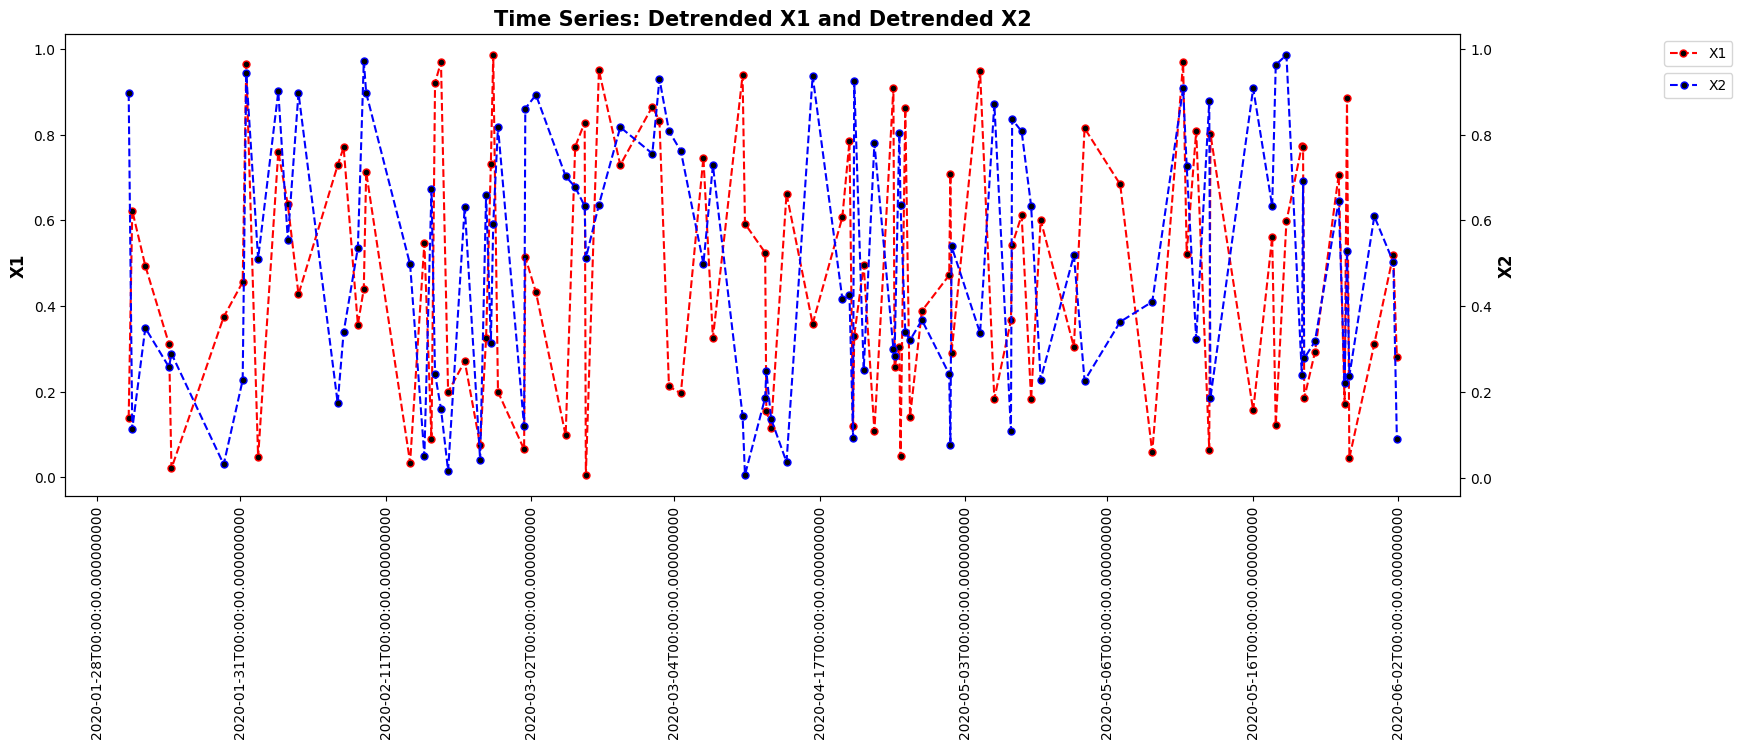

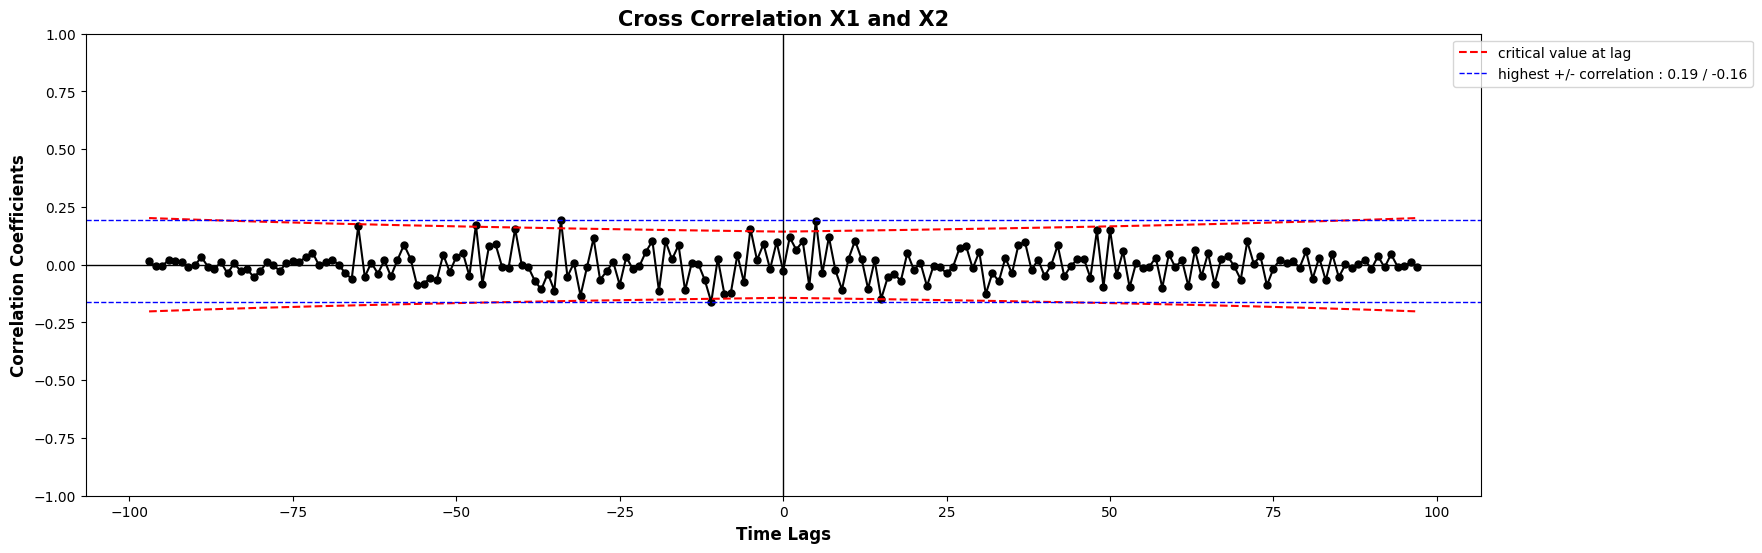

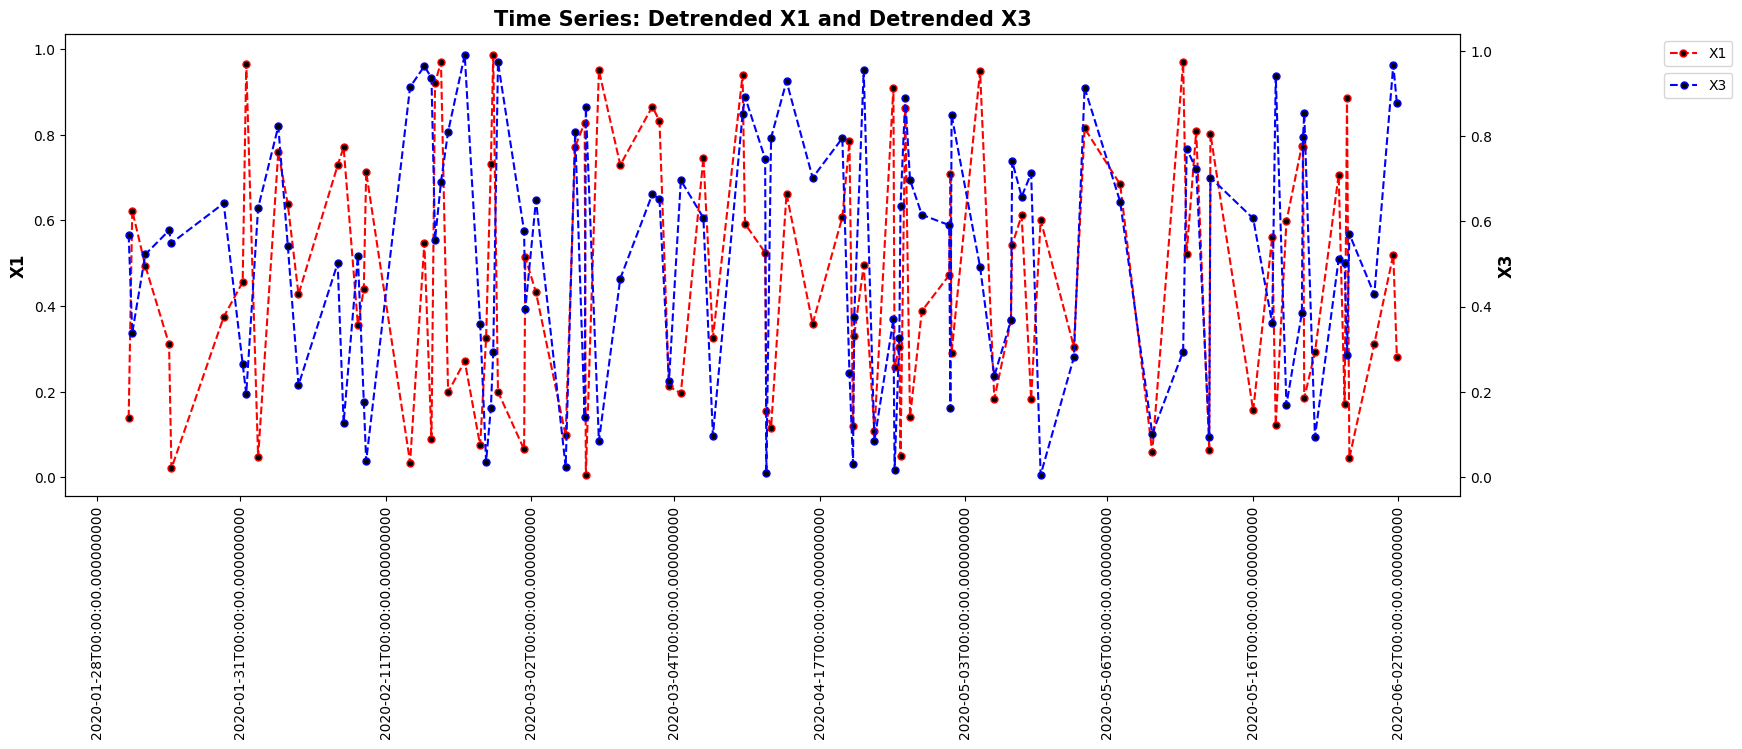

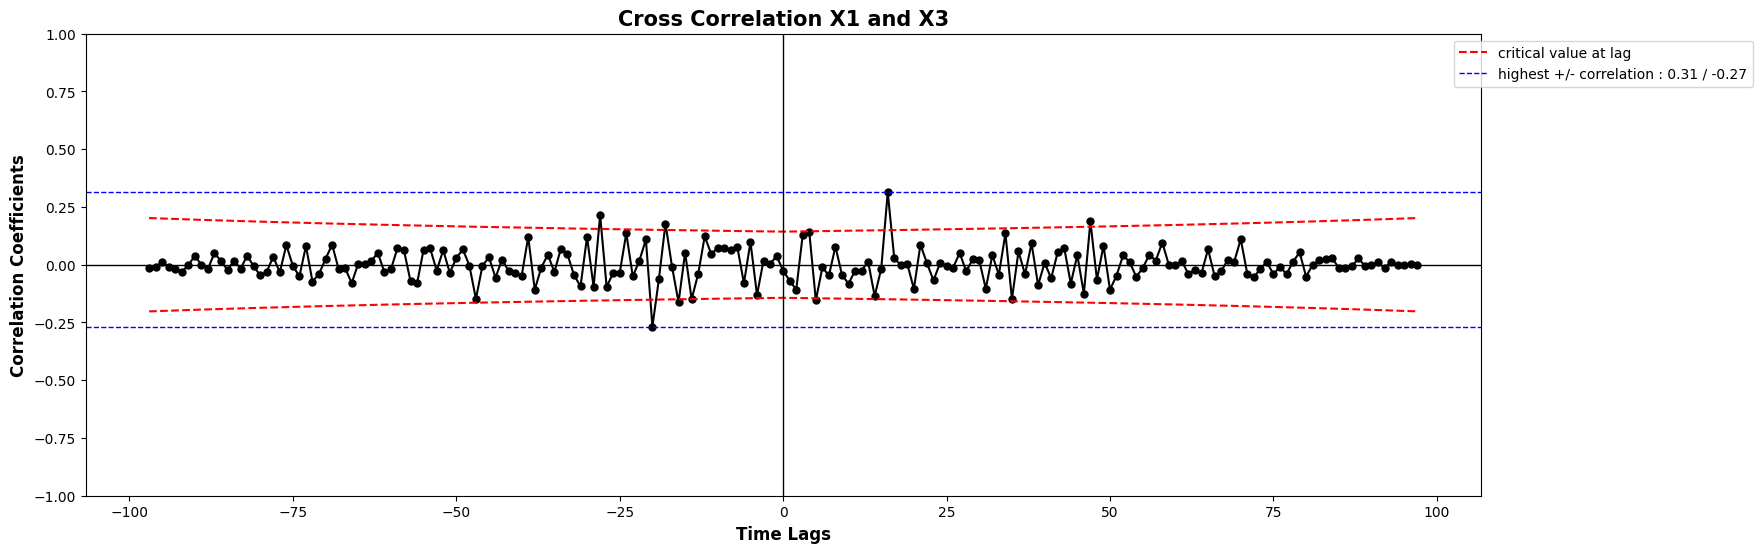

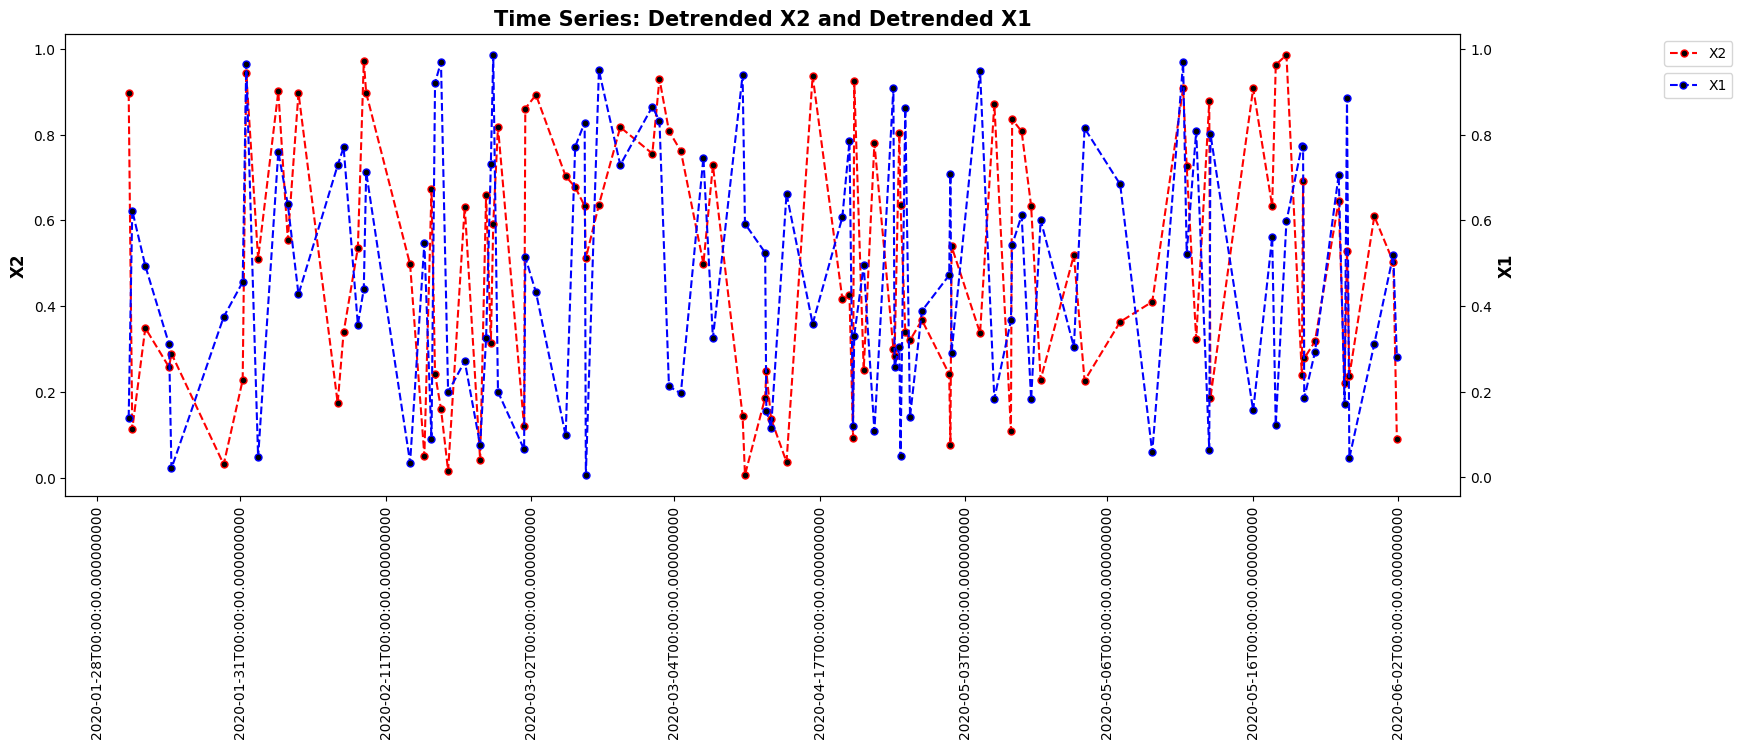

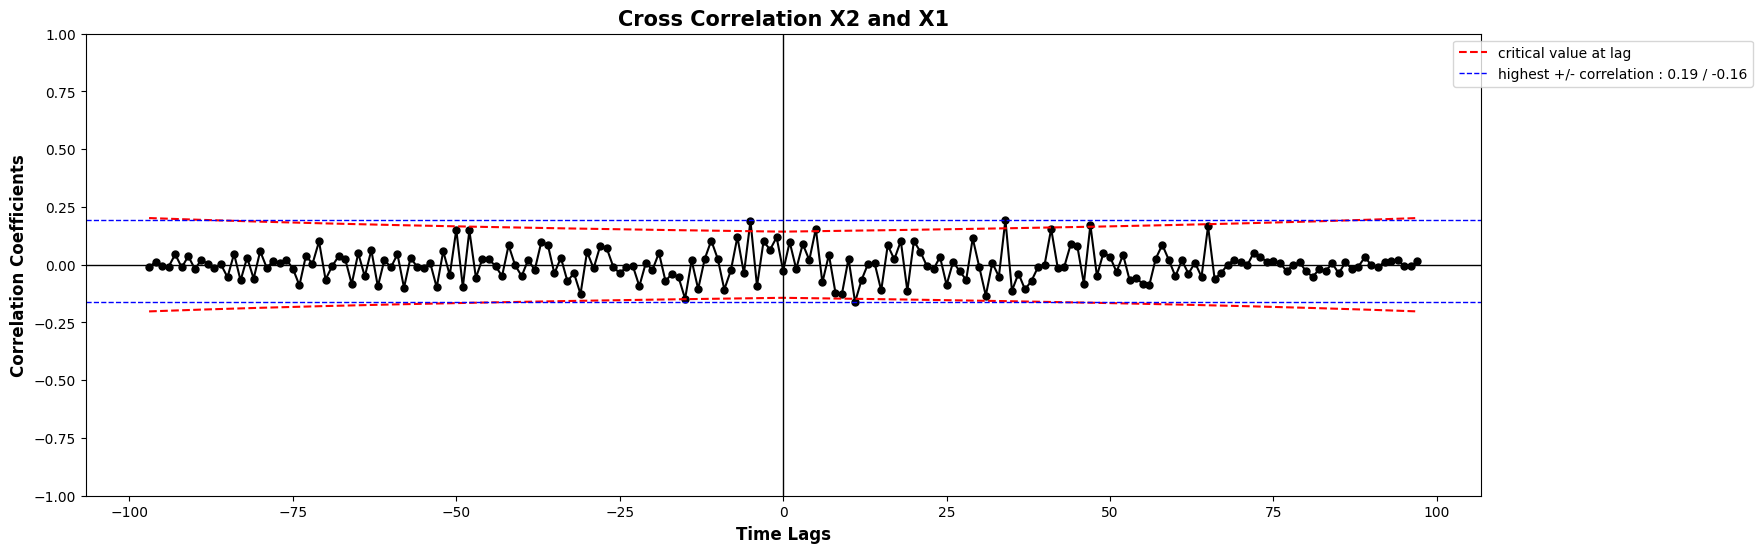

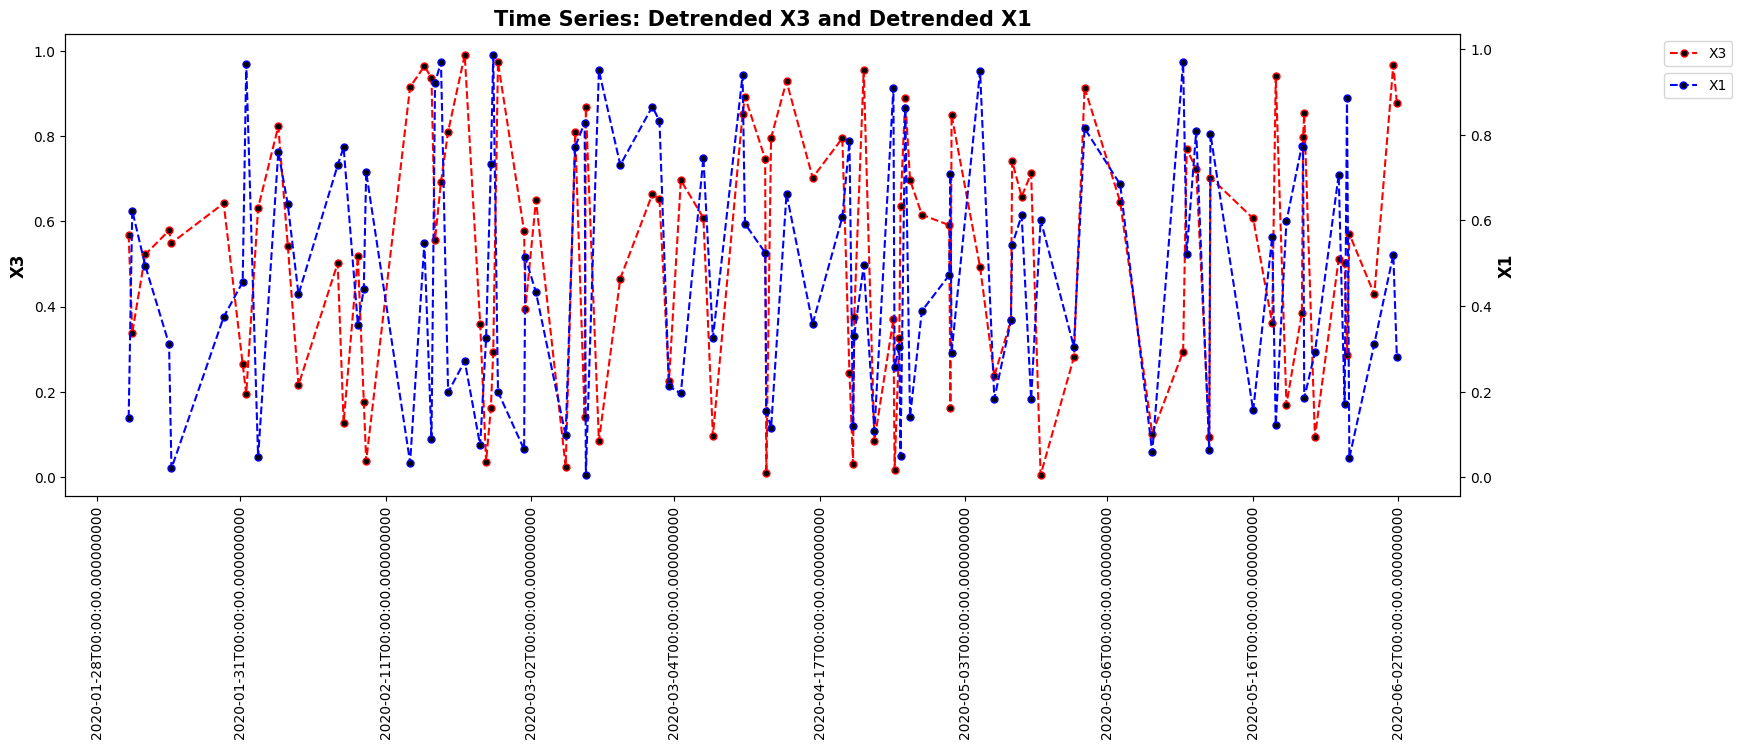

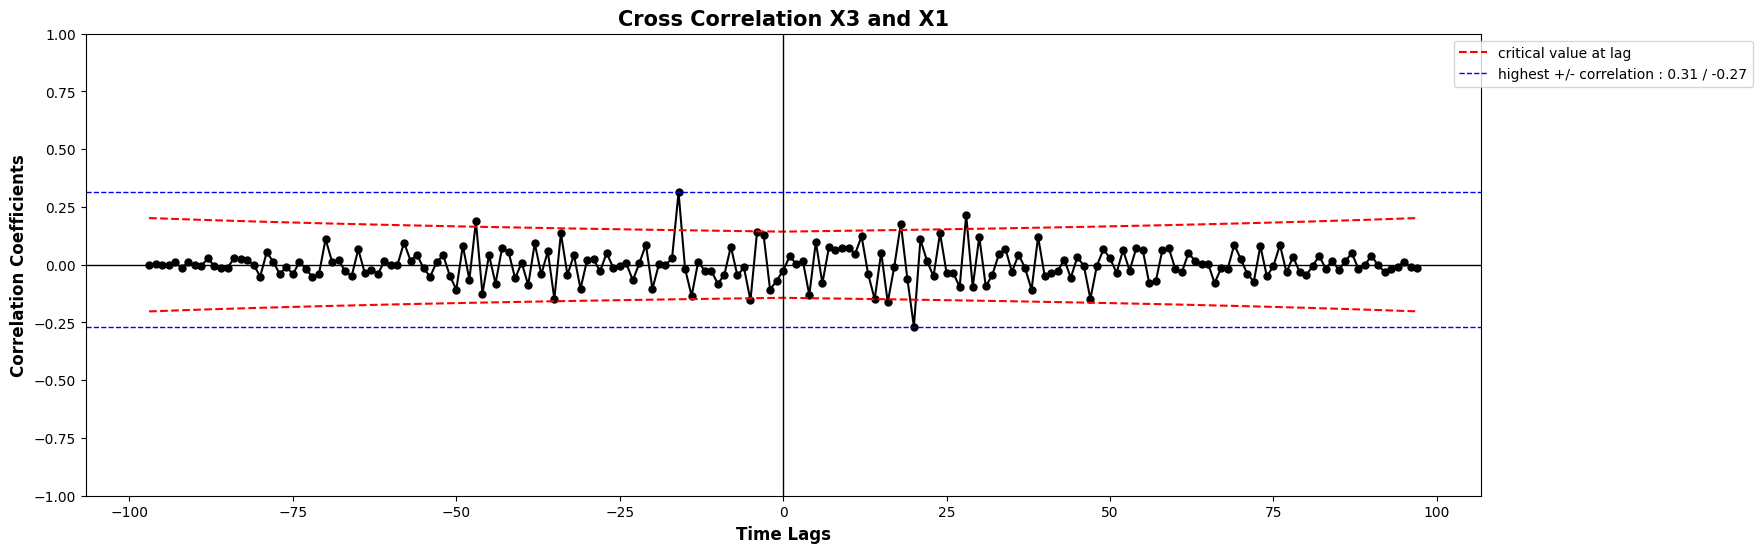

In [7]:
def two_time_series_relations(df:str,time_col:str, x_col:str, y_col:str, 
                              significance_value:float = 0.01, plots:bool = True, de_trend:bool = True):

    # data
    df = df[[x_col,y_col]].reset_index(drop=False)
    df = df.groupby(time_col).median().reset_index()
    df = df.sort_values(time_col).reset_index(drop=True)

    # de trend data if needed
    if de_trend == True:
        detrended_x , detrended_y = detrend(df,time_col, x_col, y_col)
        df['Detrended X'] = detrended_x.values
        df['Detrended Y'] = detrended_y.values 

        # cross correlations
        c = time_lag_correlations(df,'Detrended X','Detrended Y')

        # time series plots
        title_label = f'Time Series: Detrended {x_col} and Detrended {y_col}'

        # correlations with lags
        lags = signal.correlation_lags(len(df['Detrended X']), len(df['Detrended Y']))
        vis1 = two_time_series_plot(df,time_col, 'Detrended X', 'Detrended Y',label = title_label)
        vis2 = time_lag_corr_plot(c,lags,'Detrended X','Detrended Y')

    else:
        # cross correlations
        c = time_lag_correlations(df,x_col,y_col)

        # time series plots
        title_label = 'Time Series: ' + x_col + ' and ' + y_col

        # time series plots
        title_label = f'Time Series: Detrended {x_col} and Detrended {y_col}'

        # correlations with lags
        lags = signal.correlation_lags(len(df[x_col]), len(df[y_col]))
        vis1 = two_time_series_plot(df,time_col, x_col, y_col,label = title_label)
        vis2 = time_lag_corr_plot(c,lags,x_col,y_col)


    #calling plot objects
    vis1
    vis2

    correlations_df = pd.DataFrame(c,
                                  index=[lags],
                                  columns = ['Correlations per lag'])

    return df, correlations_df

def time_lag_corr_plot(corr,lags,x_col,y_col,significance_value = 0.01,size=(18, 6)):
    lag = lags
    n = len(corr)
    cutoff = critical_corr(samples_size = n ,lag = lag)
    cutoff_l = []
    for i in cutoff:
        cutoff_l.append(-1*i)

    fig, ax = plt.subplots(figsize = size)
    ax.plot(lags, corr,c='black', mfc='black',marker=".", ms=10)
    ax.plot(lags, cutoff,c='red',label = 'critical value at lag',mfc='black', linestyle='dashed', ms=10)
    ax.plot(lags, cutoff_l,c='red', mfc='black', linestyle='dashed', ms=10)
    ax.axvline(x = 0, color = 'black', lw = 1)
    ax.axhline(y = 0, color = 'black', lw = 1)
    ax.axhline(y = np.max(corr), color = 'blue',linestyle='dashed', lw = 1, label = 'highest +/- correlation : ' + str(round(np.max(corr),2)) + ' / ' + str(round(np.min(corr),2)))
    ax.axhline(y = np.min(corr), color = 'blue',linestyle='dashed', lw = 1)
    ax.set(ylim = [-1, 1])
    ax.set_title(f'Cross Correlation {x_col} and {y_col}', weight='bold', fontsize = 15)
    ax.set_ylabel(f'Correlation Coefficients', weight='bold', fontsize = 12)
    ax.set_xlabel(f'Time Lags', weight='bold', fontsize = 12)
    ax.legend(bbox_to_anchor=(1.2, 1))

def critical_corr(samples_size,lag): 
    crit_corr = []
    for i in range(0,samples_size):
        crit_corr.append( 2 / ( samples_size - np.abs(lag[i]) )**.5 )
    return crit_corr 

def two_time_series_plot(df,time_col, x_col, y_col, c='red', marker=".", size=(18, 6),
                         mfc='black', linestyle='dashed', ms=10, label = None):
                      
    fig, ax1 = plt.subplots(figsize =size)
    ax1.set_title(label, weight='bold', fontsize = 15)
    ax2 = ax1.twinx()

    ax1.plot(df[time_col], df[x_col],
                        c=c,marker=marker,mfc=mfc,
                        linestyle=linestyle,ms=ms,label=x_col)

    ax2.plot(df[time_col], df[y_col],
                        c='blue',marker=marker,mfc=mfc,
                        linestyle=linestyle,ms=ms,label=y_col)


    ax1.legend(bbox_to_anchor=(1.2, 1))
    ax2.legend(bbox_to_anchor=(1.2, 0.93))
    ax1.set_xticklabels(df[time_col].values, rotation=90)
    ax1.set_ylabel(x_col, weight='bold', fontsize = 12)
    ax2.set_ylabel(y_col, weight='bold', fontsize = 12);

def time_lag_correlations(df,x_col,y_col):
    p = df[x_col]       
    q = df[y_col]
    p = (p - np.mean(p)) / (np.std(p) * len(p))
    q = (q - np.mean(q)) / (np.std(q))  

    # cross correlations
    c = np.correlate(p, q, 'full')

    return c
  
def detrend(df,time_col, x_col, y_col):
    # de - trend time series x
    x_df = signal.detrend(df[x_col])
    detrended_x = pd.DataFrame(x_df,columns=[x_col],index = df[time_col])
    
    # de - trend time series y
    y_df = signal.detrend(df[y_col])
    detrended_y = pd.DataFrame(y_df,columns=[y_col],index = df[time_col])

    return detrended_x , detrended_y

two_time_series_relations(df = df ,time_col = "Date",x_col = 'X1',y_col = 'X2',plots = True,de_trend = False);
two_time_series_relations(df = df ,time_col = "Date",x_col = 'X1',y_col = 'X3',plots = True,de_trend = False);
two_time_series_relations(df = df ,time_col = "Date",x_col = 'X2',y_col = 'X1',plots = True,de_trend = False);
two_time_series_relations(df = df ,time_col = "Date",x_col = 'X3',y_col = 'X1',plots = True,de_trend = False);